<a href="https://colab.research.google.com/github/gauravbaluni/covaxine/blob/main/Seismic_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result
"""Multivariate Time Series"""
occ_data = pd.read_csv('/content/drive/MyDrive/tiru_filltered.csv',parse_dates=['TimeStamp'])
occ_data = occ_data.set_index('TimeStamp')
occ_data.head()

,BGCorrected,Temperature,Humidity,BattVoltage,PMTVoltage,Pressure
TimeStamp,,,,,,
2021-02-19 11:00:00,302.5,44.9,31.6,6.28,806,1014
2021-02-19 11:15:00,272.5,44.9,31.6,6.26,810,1016
2021-02-19 11:45:00,305.0,44.9,31.6,6.20,818,1021
2021-02-19 12:00:00,285.0,44.9,31.6,6.25,821,1023
2021-02-19 12:15:00,367.5,44.9,31.6,6.31,825,1025


In [7]:
import matplotlib.pyplot as plt

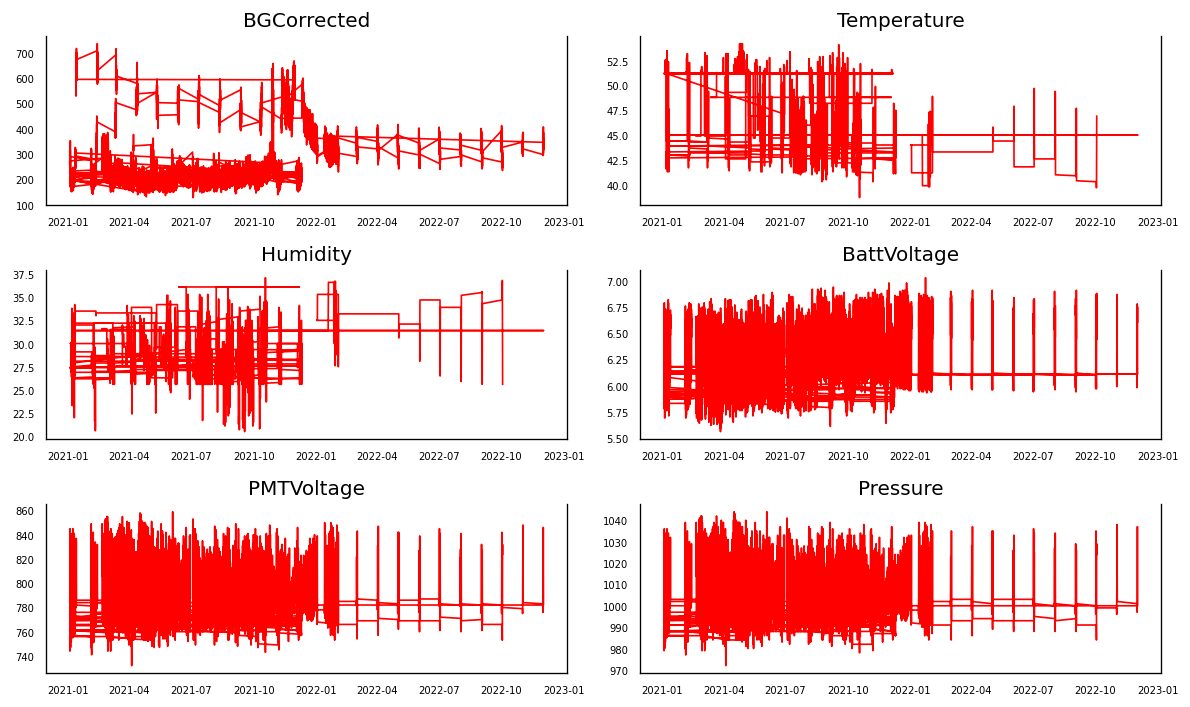

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = occ_data[occ_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(occ_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

In [ ]:
adf_test_results = {
    col: test_stationarity(occ_data, col)
    for col in occ_data.columns
}



In [ ]:
adf_test_results

{'BGCorrected': 'Non-Stationary',
 'BattVoltage': 'Stationary',
 'Humidity': 'Stationary',
 'PMTVoltage': 'Stationary',
 'Pressure': 'Stationary',
 'Temperature': 'Stationary'}

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in occ_data.columns:
    occ_data[col] = differencing(occ_data, col, 1)

In [ ]:
from statsmodels.tsa.api import VAR
max_lag = 20
var_model = VAR(occ_data)
# select the best lag order
lag_results = var_model.select_order(max_lag)
selected_lag = lag_results.aic
print(selected_lag) # selected_lag = 13

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20


In [ ]:
import numpy as np

In [ ]:
def find_anomalies(squared_errors):
    threshold = np.mean(squared_errors) + np.std(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold
var = VAR(occ_data)
var_fitresults = var.fit(selected_lag)
squared_errors = var_fitresults.resid.sum(axis=1) ** 2
predictions, threshold = find_anomalies(squared_errors) # threshold = 7593.829254818655

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
predictions, threshold

(TimeStamp
 19-02-21 16:34    0
 19-02-21 16:49    0
 19-02-21 17:04    1
 19-02-21 17:19    1
 19-02-21 17:34    0
                  ..
 10-02-22 16:33    0
 10-02-22 16:48    0
 10-02-22 17:03    0
 10-02-22 17:18    0
 10-02-22 17:33    0
 Length: 34028, dtype: int64, 1165.4184655391216)

In [ ]:
threshold = np.mean(squared_errors) + 1 * np.std(squared_errors)

In [ ]:
data = occ_data.iloc[selected_lag:, :]
data['Predictions'] = predictions.values
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,BGCorrected,Temperature,Humidity,BattVoltage,PMTVoltage,Pressure,Predictions
TimeStamp,,,,,,,
19-02-21 16:34,-2.5,0.0,0.0,-0.03,-1.0,-1.0,0
19-02-21 16:49,35.0,0.0,0.0,0.12,-1.0,0.0,0
19-02-21 17:04,-62.5,0.0,0.0,-0.04,-1.0,-1.0,1
19-02-21 17:19,-5.0,0.0,0.0,0.12,-3.0,-2.0,1
19-02-21 17:34,15.0,0.0,0.0,-0.09,-2.0,-1.0,0
...,...,...,...,...,...,...,...
10-02-22 16:33,15.0,0.0,0.0,0.02,-1.0,-1.0,0
10-02-22 16:48,28.0,0.0,0.0,0.34,-1.0,0.0,0
10-02-22 17:03,-35.0,0.0,0.0,-0.15,-1.0,-1.0,0


In [ ]:
data.to_csv('outfile.csv')

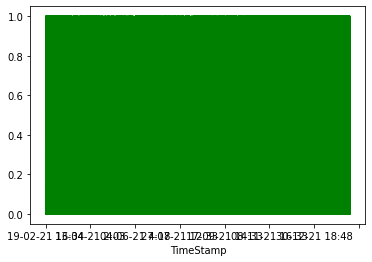

In [ ]:
data.Predictions.plot(color='Green')

In [ ]:
data.index = pd.to_datetime(data.T, dayfirst=True)


KeyError: ignored

In [ ]:
data['Predictions'].value_counts()

0    30828
1     3200
Name: Predictions, dtype: int64